# Estudio de Ascenso de Gradientes con una distribución Benoulli

En este estudio vamos a utilizar una distribución Bernoulli, en la que, básicamente, un brazo sólo puede dar dos resultados, de éxito, 1, o de fracaso, 0.

In [ ]:
import numpy as np
from typing import List

from algorithms import Algorithm, Softmax, GradientBandit
from arms.armbernoulli import ArmBernoulli
from arms import Bandit
from plotting import plot_average_rewards, plot_regret

['C:\\Users\\jasf7\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'C:\\Users\\jasf7\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'C:\\Users\\jasf7\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'C:\\Users\\jasf7\\AppData\\Local\\Programs\\Python\\Python312', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml', '', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml\\Lib\\site-packages', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml\\Lib\\site-packages\\win32', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml\\Lib\\site-packages\\win32\\lib', 'd:\\Escritorio\\Universidad\\master\\Asignaturas\\EML\\Practica1\\k_brazos_SFDD\\veml\\Lib\\site-packages\\Pythonwin', './src/']


In [2]:
seed = 42
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    optimal_reward = bandit.get_expected_value(optimal_arm) # Recompensa esperada del brazo óptimo.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz del rechazo acumulado

    arm_stats = [(algo, {arm: [0, 0] for arm in range(len(bandit.arms))}) for algo in algorithms] # TODO: Lista para almacenar estadísticas por cada algoritmo

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        cumulative_regret = np.zeros(len(algorithms))   # Acumulador de rechazo acumulado por algoritmo.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # TODO: (arm_statistics) Buscar el conjunto de estadísticas correspondiente a este algoritmo
                _, stats = arm_stats[idx]
                # Registrar selecciones y recompensas en arm_stats
                stats[chosen_arm][0] += 1  # Contador de selecciones
                stats[chosen_arm][1] += reward  # Suma de recompensas

                #TODO: (optimal_selections) modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Cálculo del rechazo
                regret = optimal_reward - reward  
                cumulative_regret[idx] += regret  # Acumular regret total
                regret_accumulated[idx, step] += cumulative_regret[idx] 


    rewards /= runs

    # TODO: (optimal_selections) calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje

    regret_accumulated /= runs  # Calcular el rechazo acumulado promedio

    # TODO: (arm_statistics) Calcular la recompensa promedio para cada brazo
    for _, stats in arm_stats:
        for arm in stats:
            selections, total_reward = stats[arm]
            stats[arm] = (selections, total_reward / selections if selections > 0 else 0)

    return rewards, optimal_selections, arm_stats, regret_accumulated

## Softmax

Para este algoritmo, vamos a utilizar su parámetro τ, que controla el equilibrio entre exploración y explotación.
- Si τ es grande, todos los brazos tienen probabilidades similares para ser elegidos, lo que promueve la exploración.
- Si τ es pequeña, el brazo con mayor recompensa estimada se elige con mayor probabilidad, lo que prioriza la explotación.
- Si τ es 0, el algoritmo se comporta como un greedy puro, escogiendo siempre el mejor brazo estimado (pura explotación).

In [3]:

# Parámetros del experimento
seed = 42
# Fijar la semilla para reproducibilidad
np.random.seed(seed)  

# Número de brazos
k = 10 
# Número de pasos que se ejecutarán cada algoritmo
steps = 1000
# Número de ejecuciones  
runs = 500  

# Generar un bandido con k brazos de distribución Bernoulli
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) 
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
softmax_algorithms = [Softmax(k=k, temperature=0.1), Softmax(k=k, temperature=0.5), Softmax(k=k, temperature=2)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
softmax_rewards, softmax_optimal_selections, softmax_arm_stats, softmax_regret_accumulated = run_experiment(bandit, softmax_algorithms, steps, runs)

Bandit with 10 arms: ArmBernoulli(p=0.39963209507789), ArmBernoulli(p=0.8605714451279329), ArmBernoulli(p=0.685595153449124), ArmBernoulli(p=0.5789267873576293), ArmBernoulli(p=0.22481491235394924), ArmBernoulli(p=0.22479561626896213), ArmBernoulli(p=0.14646688973455957), ArmBernoulli(p=0.7929409166199481), ArmBernoulli(p=0.5808920093945671), ArmBernoulli(p=0.6664580622368363)
Optimal arm: 2 with expected reward=0.8605714451279329


### Recompensa promedio

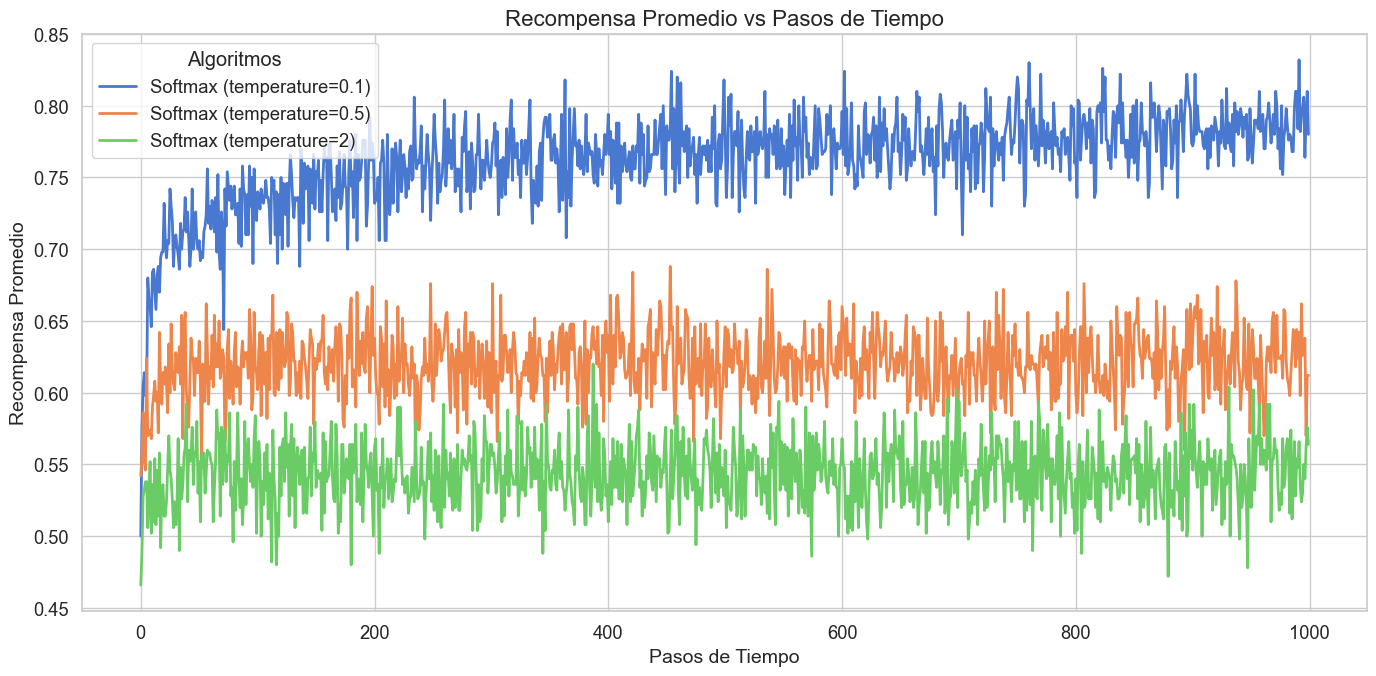

In [4]:
plot_average_rewards(steps, softmax_rewards, softmax_algorithms)

En la gráfica se pueden observar las recompensas promedios obtenidas de tres configuraciones distintas para el algoritmo Softmax, modificando el valor para su parámetro τ. De primeras, podemos observar que hay mucho ruido, esto puede deberse a que estamos tratando con una distribución Bernoulli, y hay una naturaleza inherentemente estocástica en las recompensas. Esto puede llevar a fluctuaciones significativas en las recompensas, especialmente si el número de pasos de tiempo es relativamente pequeño.

- **Softmax (temperature=0.1):** muestra la recompensa promedio más alta, esto sugiere que con una temperatura baja, el algoritmo explora menos y explota más las opciones conocidas. La recompensa promedio se mantiene relativamente estable y alta, lo que indica que la configuración es eficiente para encontrar la mejor opción posible.
- **Softmax (temperature=0.5):** tiene una recompensa promedio entre las temperaturas de 0.1 y 2, lo que indica que hay un equilibrio entre exploración y explotación. Con una temperatura moderada, el algoritmo puede adaptarse mejor a nuevas opciones sin comprometer demasiado la recompensa promedio. Esto puede ser útil en escenarios donde es necesario un equilibrio entre exploración y explotación.
- **Softmax (temperature=2):** obtiene la recompensa promedio más baja, esto sugiere que con una temperatura alta, el algoritmo explora más y explota menos, lo que lleva a una menor recompensa promedio. on una temperatura alta, el algoritmo tiende a explorar mucho más, probando diferentes opciones y aprendiendo sobre ellas. Esto es útil en escenarios donde es importante explorar exhaustivamente todas las opciones disponibles.

### Rechazo acumulado

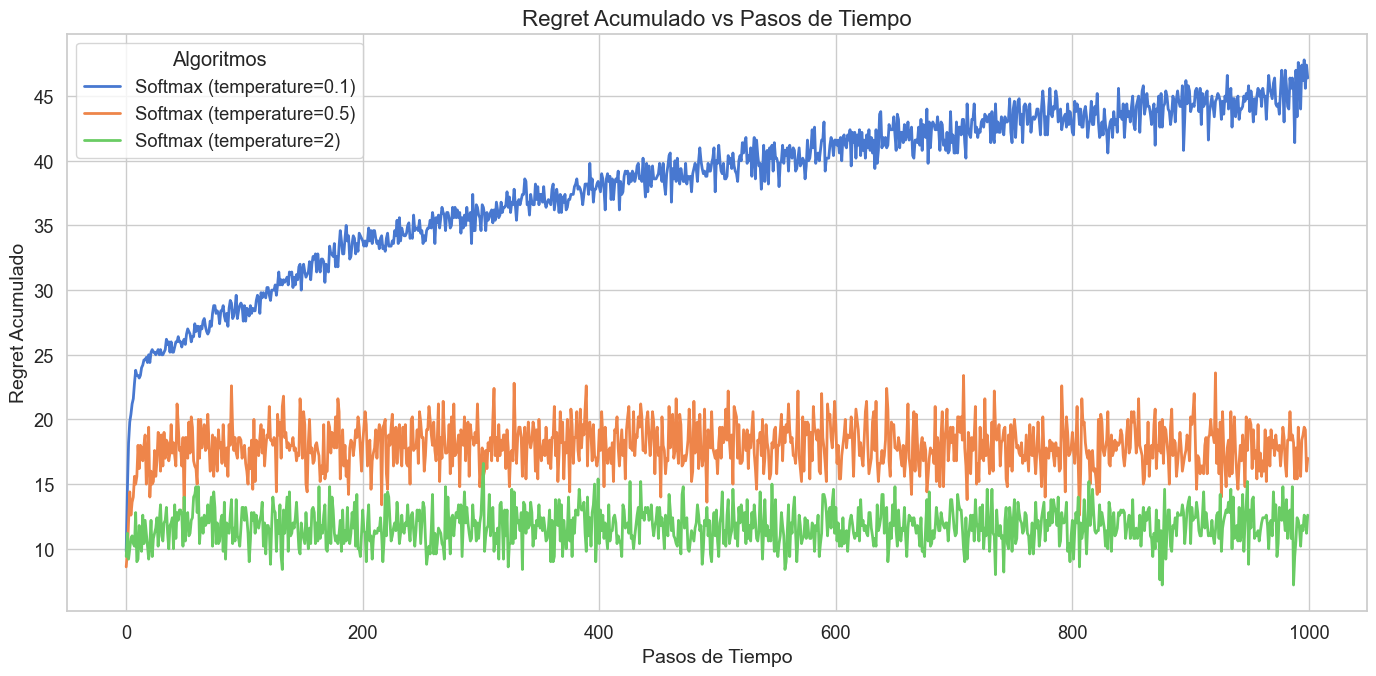

In [5]:
plot_regret(steps, softmax_optimal_selections, softmax_algorithms)

En esta gráfica se muestra el rechazo acumulado obtenido por parte de los tres algoritmos:

- **Softmax (temperature=0.1):** muestra un aumento constante del rechazo obtenido a lo largo del tiempo. Esto significa que, como hemos dicho antes, el algoritmo explora menos y explota más las opciones conocidas. Sin embargo, esto también puede llevar a una mayor acumulación de errores, ya que el algoritmo no explora suficientemente las opciones.
- **Softmax (temperature=0.5):** tiene un rechazo estable con algunas fluctuaciones, y parece equilibrar bien la exploración y la explotación, minimizando el regret acumulado de manera más efectiva que con la temperatura de 0.1.
- **Softmax (temperature=2):** muestra el regret acumulado más bajo y más estable entre las tres configuraciones. Esto sugiere que con una temperatura alta, el algoritmo explora mucho más, lo que permite descubrir las mejores opciones y minimizar el regret acumulado a largo plazo.

Ahora, nos hemos encontrado con una cuestión interesante, ¿por qué con una temperatura de 0.01 se obtiene la mejor recompensa promedio pero el peor rechazo acumulado?
Creemos que el algoritmo, al estar equilibrando una exploración cuidadosa y una explotación eficiente, le lleva a una mayor recompensa promedio a largo plazo. Sin embargo, la exploración prolongada y la adaptación lenta dan lugar a un mayor rechazo acumulado.

## Gradiente de preferencias

Para este algoritmo se utiliza α como parámetro, que es el paso de actualización del gradiente y controla la tasa de aprendizaje del algoritmo
- Si α es pequeña, el aprendizaje del algoritmo será más lento pero más estable.
- Si α es grande, el aprendizaje será más rápido, pudiendo producirse oscilaciones o inestabilidad.

In [11]:
# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
gradient_algorithms = [GradientBandit(k=k, alpha=0.01), GradientBandit(k=k, alpha=0.1), GradientBandit(k=k, alpha=0.5)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
gradient_rewards, gradient_optimal_selections, gradient_arm_stats, gradient_regret_accumulated = run_experiment(bandit, gradient_algorithms, steps, runs)

### Recompensa promedio

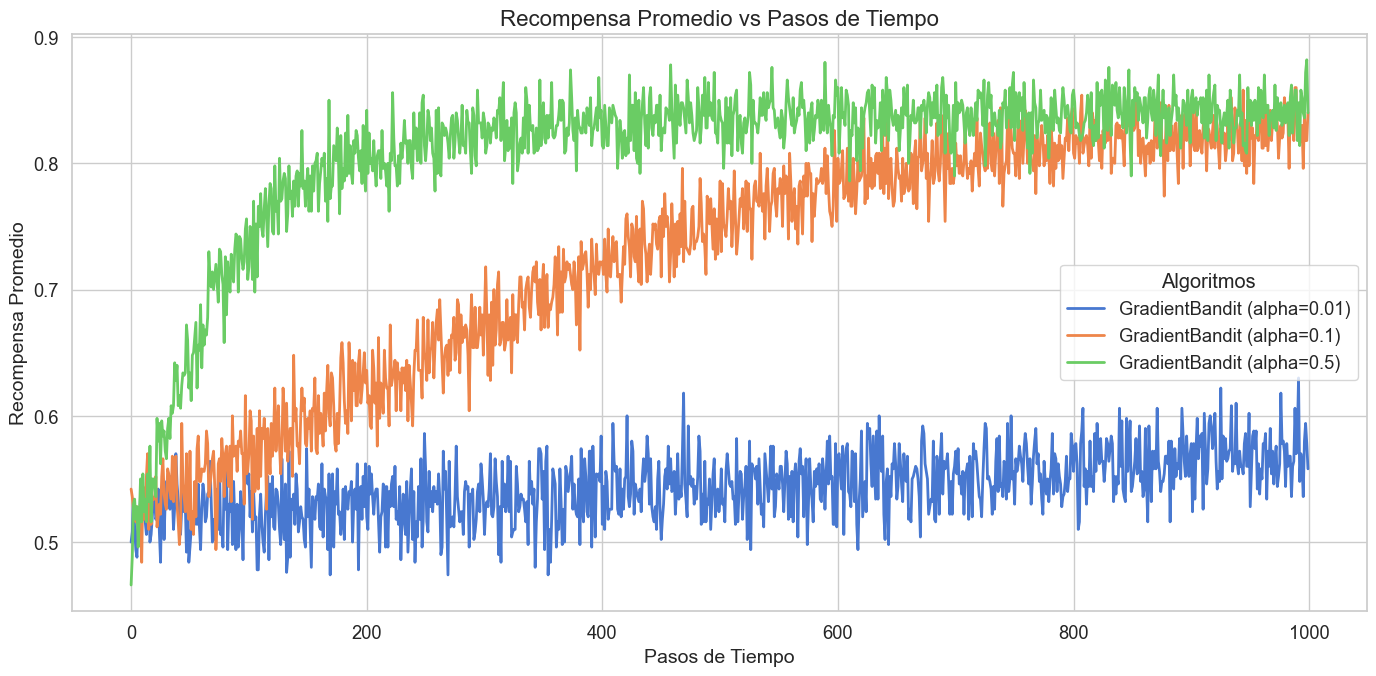

In [12]:
plot_average_rewards(steps, gradient_rewards, gradient_algorithms)

- **GradientBandit (alpha=0.01):** tiene la recompensa promedio más baja, su bajo valor de alpha implica que el algoritmo aprende más lento (aunque poco a poco va aumentando su recompensa promedio), lo que puede llevar a que tarde más en adaptarse y descubrir las acciones óptimas.
- **GradientBandit (alpha=0.1):** presenta una recompensa promedio intermedia entre los otros dos algoritmos. Con un alpha mayor, el algoritmo es capaz de aprender y adaptarse más rápidamente en comparación con el de alpha=0.01.
- **GradientBandit (alpha=0.5):** tiene la recompensa promedio más alta. En este algoritmo se puede observar que un alpha más alto permite al algoritmo aprender y adaptarse mucho más rápido, maximizando la recompensa a lo largo del tiempo.

En esta gráfica se puede observar la importancia del parámetro alpha, que, representando la capacidad de aprendizaje del algoritmo, cuanto mayor es su valor, conduce al algoritmo a tener un mejor rendimiento en términos de recompensa promedio a lo largo del tiempo.

### Rechazo acumulado

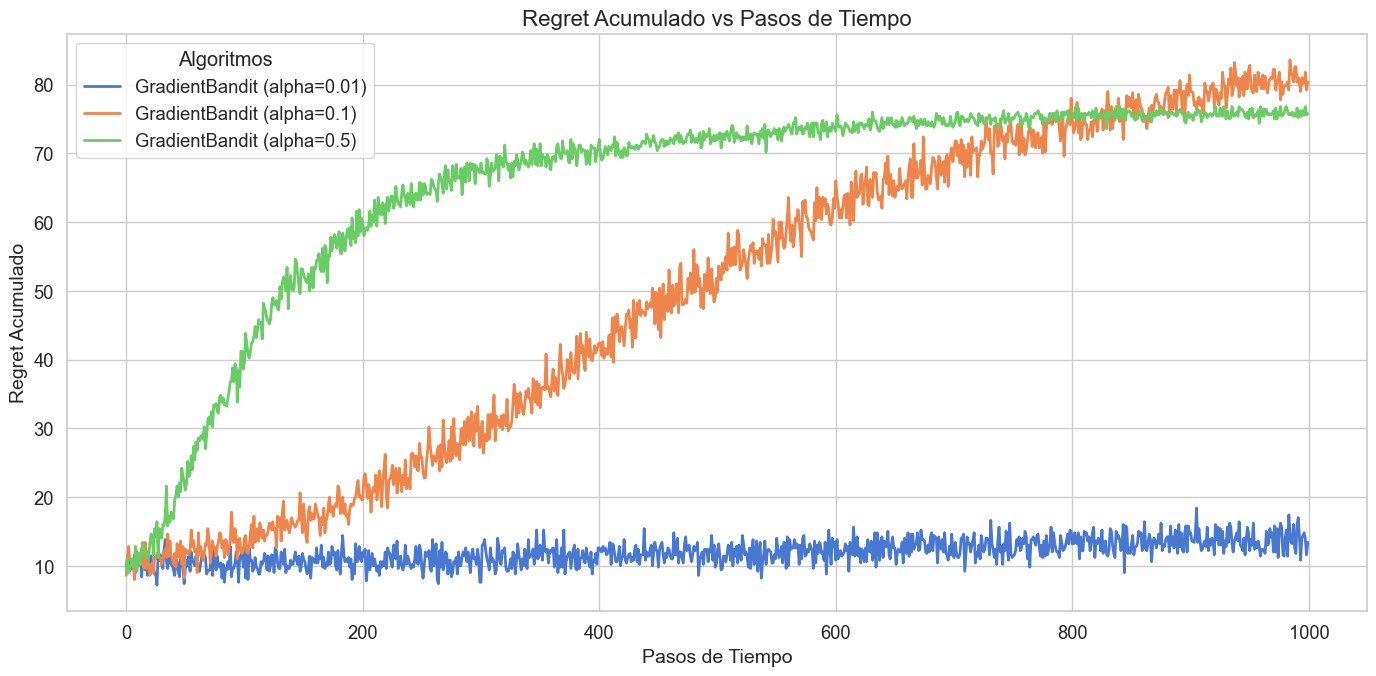

In [16]:
plot_regret(steps, gradient_optimal_selections, gradient_algorithms)

- **GradientBandit (alpha=0.01):** muestra el rechazo acumulado más bajo entre las tres configuraciones. Esto sugiere que, con una tasa de aprendizaje baja, el algoritmo tiende a explorar mucho menos y, por lo tanto, el rechazo acumulado obtenido se mantiene más constante.
- **GradientBandit (alpha=0.1):** tiene un rechazo acumulado que se encuentra entre las configuraciones de α=0.01 y α=0.5. Al igual que en la recompensa promedio, indica un equilibrio entre exploración y explotación.
- **GradientBandit (alpha=0.5):** la alta tasa de aprendizaje permite explorar de manera más agresiva y descubrir rápidamente las mejores acciones, lo que puede llevar a que, inicialmente, se obtengan valores altos de rechazo debido a ese proceso de aprendizaje, hasta que se estabiliza porque ya conoce mejor las mejores opciones.

En resumen, un alpha más alto tiende a resultar en un mayor rechazo acumulado debido a una exploración más agresiva (fruto de ese proceso de aprendizaje), mientras que un alpha más bajo lleva a menor rechazo debido a una exploración más cuidadosa.

## Softmax vs Gradiente de preferencias

En este apartado vamos a comparar ambos algoritmos.

### Recompensa promedio

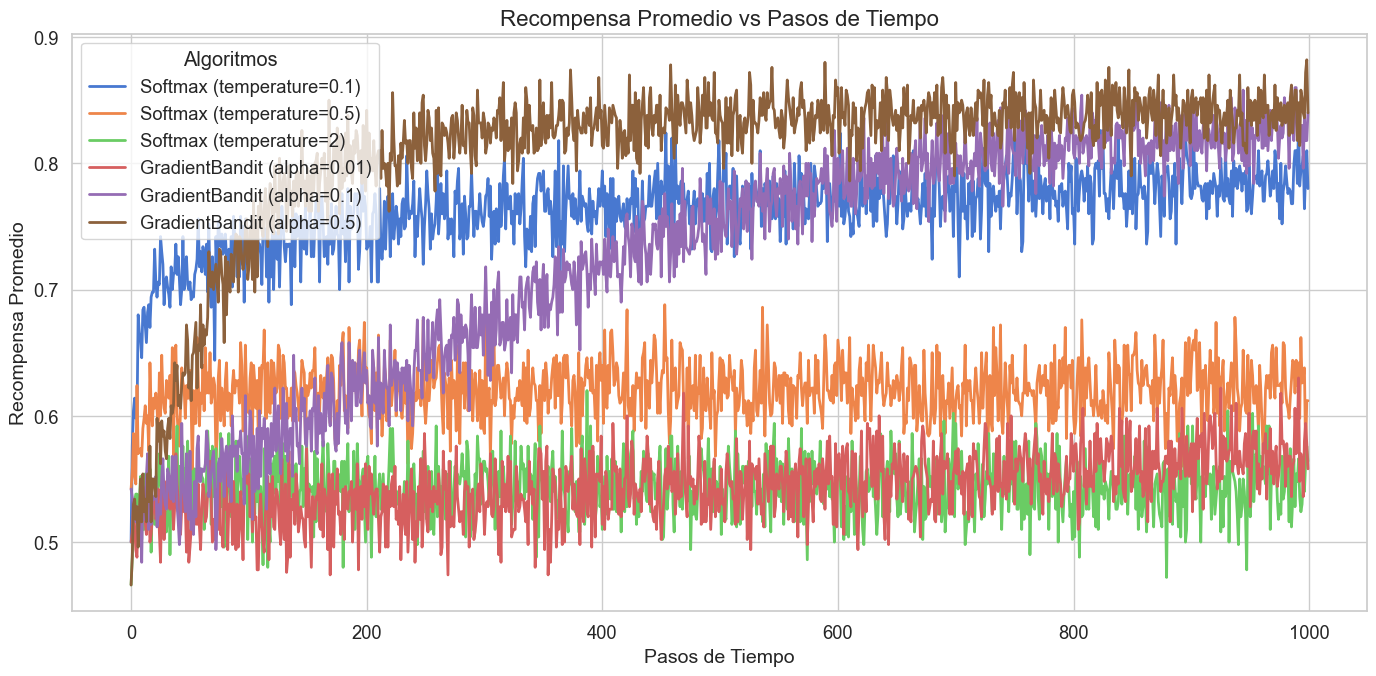

In [14]:
plot_average_rewards(steps, np.vstack((softmax_rewards, gradient_rewards)), softmax_algorithms+gradient_algorithms)

La mayor recompensa promedio se obtiene mediante Gradiente de Preferencias, con un valor para el alpha de 0.5, acercándose a una recompensa de 0.85, lo cuál está bastante bien. La peor se obtiene en Gradiente de preferencias con alpha=0.1, estando alrededor de 0.55, al menos inicialmente, aunque este puesto también lo pelea con Softmax, con una temperatura de 2.

Softmax con una temperatura baja y GradientBandit con un alpha alto equilibran bien la exploración y explotación, permitiendo un rápido ajuste y maximización de recompensas. Softmax con alta temperatura tiende a sobre-explorar, mientras que GradientBandit con bajo alpha tarda en adaptarse.

### Rechazo acumulado

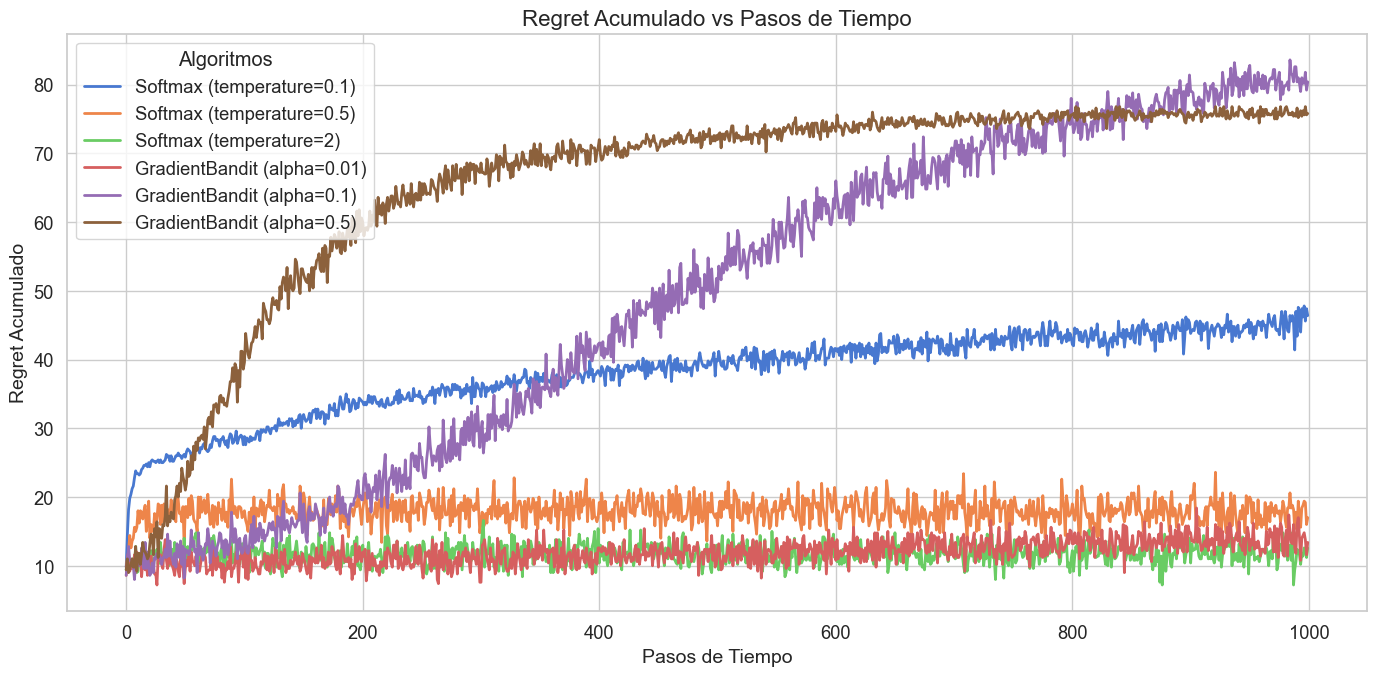

In [15]:
plot_regret(steps, np.vstack((softmax_optimal_selections, gradient_optimal_selections)), softmax_algorithms+gradient_algorithms)

Vemos como el mayor rechazo acumulado es obtenido en GradientBandit (alpha=0.1), esto se debe a la exploración prolongada inicial, a pesar de la explotación eficiente a largo plazo.

Tanto Softmax como Gradiente de Preferencias pueden ser efectivos, pero requieren ajustes específicos en sus parámetros para obtener los mejores resultados. Softmax con una temperatura baja y GradientBandit con un alpha alto son óptimos para maximizar las recompensas promedio, mientras que para minimizar el regret acumulado, Softmax con una temperatura baja y GradientBandit con un alpha bajo son más adecuados.